# Analysis of Proportional Probability Over Time for Mouse Purkinji Neurons Spike Configurations

## objective
In this notebook we will be exploring the anatomy of energy over time. The Ising model is a statistical physics model used for studing phase transition in magnatic materials. Magnetized material consist of electrons all organized in a general direction. This direction determines the structure of the magnetic field, the collected organization gives stength to the field. Using the Ising model an individual could observe the collective organization phase's. By varying temperature in the model, various emergent behavior can be observed. Something of value the model provides is the energy per states, energy can be used to measure proabability. Due to limitation in computation, it is not possible to gain the actual probability of a spin configuration. Instead you can gain the proportion of probability per spin configuration. I do not view this as a detriment but a unqiue attribute of the puzzle piece. We are limited in knowing the probability with respect to all state but can view the proportional probability with respect to known states. This allows us to making comparision to which state is more likly then others. In this notebook we will be using this relation between states to study the change in activity between various spike configuration. This will be most affective for studying emergent behavior over time with an overlap of the mouse hand kinamatics.  

## resources:
* 

# Setting up Ising model

In [1]:
# Python Modules
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# SciPy Modules
from scipy.stats import pearsonr

In [2]:
def preprocessingSpikes(spikes, binSize):
    
    convolved_spikes = 1*(np.lib.stride_tricks.sliding_window_view(spikes, binSize, axis=0).sum(axis=2) > 0)

    return convolved_spikes

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def checkPerturbationRegime(spikes, binsize):
    
    # Run convolution
    spike_bins = preprocessingSpikes(spikes, binsize)


    # Count average spike per neuron & average of expect neuron fire rate 
    avgSpikePerNeuron = np.sum(spike_bins, axis=0) / spike_bins.shape[0]
    avgExpectedNeuronFire =  np.sum(avgSpikePerNeuron) / spike_bins.shape[1]


    # Return n_c
    N_c = 1/(avgExpectedNeuronFire * binsize)
    return N_c

def binSizeScan(spikes, start=1, end=200):

    # scan over bin sizes
    N_cList = []
    for binSize in range(start, end): # range can be defined better
        N_cList += [checkPerturbationRegime(spikes, binSize)]

    return np.asarray(N_cList)

def Q_distribution(neuronsSpikeSet, numBins = 100,label=""):
    '''
        Enter in spike data, could be sampled from model or imperical
        Function will output a histogram of averege number of neurons that participated in a time frame
    '''

    # Inital params 
    numN = neuronsSpikeSet.shape[1]
    Q_samples = []
    neuronsSpikeSet = neuronsSpikeSet.copy()

    # check data is on in [0 , 1] scale, not [-1 , 1]
    if np.min(neuronsSpikeSet) == -1:
        neuronsSpikeSet[neuronsSpikeSet == -1] = 0

    for n in neuronsSpikeSet:
        
        # Fraction of neurons that fired
        Q = np.sum(n)/(numN * 2.) + 1/2.
        Q_samples += [Q]
    
    # calculate weight
    Q_samples = np.asarray(Q_samples)
    weight = np.ones_like(Q_samples) / np.prod(Q_samples.shape) 

    # plot distrbutions 
    return plt.hist(Q_samples, bins = numBins, weights=weight, alpha = 0.5, label=label, density=True) #np.histogram(Q_samples, bins=numBins)

## Loading Data

In [4]:
from coniii import *
from coniii.solvers import *
from coniii.utils import *

In [5]:
import pandas as pd
import scipy.io as spio
import numpy as np
import scipy

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], scipy.io.matlab.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.io.matlab.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, scipy.io.matlab.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)


In [6]:
# include acceleration and impulse
from scipy.interpolate import InterpolatedUnivariateSpline

def velocity_to_acceleration(timesteps, velocity):

  sp = InterpolatedUnivariateSpline(timesteps,velocity)
  return sp.derivative()(timesteps)

In [7]:
b = loadmat('../MCH-fitter/data/PCnot25trial_59_Cebra_scaled_bin10_210614.mat')

In [106]:
neural_stim = []
continous_stim = []

truncate_idx = 400

for i in b['kinAggrogate'].keys():

    print(i)
    stim = b['kinAggrogate'][i]

    neural_session = []
    continous_sessions = []

    for k in stim.keys():
        print(f"\t Organizing {k}")
        dataMatrix = np.array(stim[k])

        if k[0] == "n":

            neural_session += [dataMatrix[:truncate_idx,1:]]

        if k[0:2] == "l_":

            x = velocity_to_acceleration(dataMatrix[:truncate_idx,0], dataMatrix[:truncate_idx,-3]).reshape(-1,1)
            y = velocity_to_acceleration(dataMatrix[:truncate_idx,0], dataMatrix[:truncate_idx,-2]).reshape(-1,1)
            z = velocity_to_acceleration(dataMatrix[:truncate_idx,0], dataMatrix[:truncate_idx,-1]).reshape(-1,1)

            print(dataMatrix.shape, x.shape)

            dataMatrix = np.hstack([dataMatrix[:truncate_idx], x, y, z])

            continous_sessions += [dataMatrix[:,1:]]


    neural_stim += [neural_session]
    continous_stim += [continous_sessions]

stim_0
	 Organizing l_1
(1037, 8) (400, 1)
	 Organizing n_1
	 Organizing label_1
	 Organizing l_2
(1000, 8) (400, 1)
	 Organizing n_2
	 Organizing label_2
	 Organizing l_3
(1012, 8) (400, 1)
	 Organizing n_3
	 Organizing label_3
	 Organizing l_4
(1012, 8) (400, 1)
	 Organizing n_4
	 Organizing label_4
	 Organizing l_5
(996, 8) (400, 1)
	 Organizing n_5
	 Organizing label_5
	 Organizing l_6
(1000, 8) (400, 1)
	 Organizing n_6
	 Organizing label_6
	 Organizing l_7
(1005, 8) (400, 1)
	 Organizing n_7
	 Organizing label_7
	 Organizing l_8
(1007, 8) (400, 1)
	 Organizing n_8
	 Organizing label_8
	 Organizing l_9
(1001, 8) (400, 1)
	 Organizing n_9
	 Organizing label_9
	 Organizing l_10
(993, 8) (400, 1)
	 Organizing n_10
	 Organizing label_10
	 Organizing l_11
(1004, 8) (400, 1)
	 Organizing n_11
	 Organizing label_11
	 Organizing l_12
(999, 8) (400, 1)
	 Organizing n_12
	 Organizing label_12
	 Organizing l_13
(1000, 8) (400, 1)
	 Organizing n_13
	 Organizing label_13
	 Organizing l_14
(996

# Model

In [107]:
BIN_SIZE = 1 # Binsize used for time splitting neural data
SAMPLE_SIZE = 100000 # Sample size used for sampling
N_CPUS = 14 # Number of CPUS to use for sim, change based on machine
MAX_ITER = 75 # Max iterations for sampling
ETA = 1e-3 # Learning Rate

In [108]:
# extract and preprocess first first stim
stim_0 = neural_stim[0]
bin_cat = np.vstack(stim_0)

bin_cat_p = preprocessingSpikes(bin_cat, BIN_SIZE)
bin_cat_p = 2 * bin_cat_p - 1


N = bin_cat_p.shape[1]

In [110]:
continous_stim[0][0].shape

(400, 10)

In [111]:
solver = MCH(bin_cat_p,
             sample_size=SAMPLE_SIZE,
             rng=np.random.RandomState(0),
             n_cpus=N_CPUS,
             sampler_kw={'boost':True})

/home/user/miniconda3/envs/test/lib/python3.10/site-packages/coniii/solvers.py:96: UserWarning: Assuming that calc_observables should be for Ising model.
  if iprint: warn("Assuming that calc_observables should be for Ising model.")
/home/user/miniconda3/envs/test/lib/python3.10/site-packages/coniii/samplers.py:1180: UserWarning: Assuming that the model is Ising.
  if iprint: warn("Assuming that the model is Ising.")


In [112]:
# begin fitting
def learn_settings(i):
    print(i)
    return {'maxdlamda': 1, 'eta':ETA}

stim_0_multipliers = solver.solve(maxiter=MAX_ITER,
                n_iters=N*10,
                burn_in=N*10,
                iprint="detailed",
                custom_convergence_f=learn_settings)

0
0
0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0
It

# Verify the quality of fit

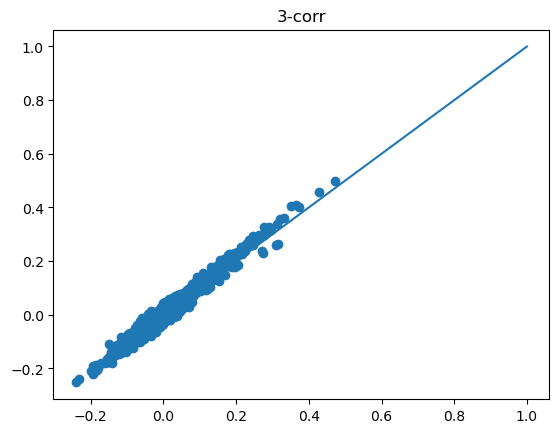

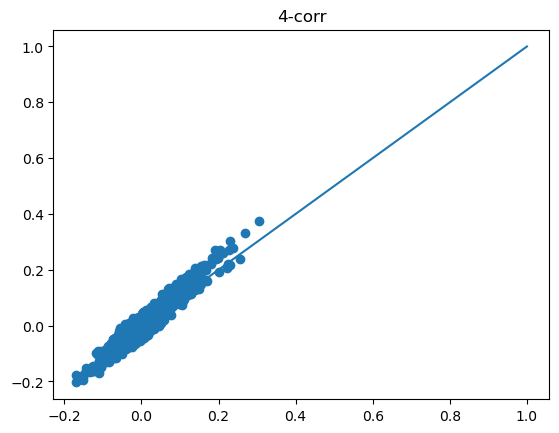

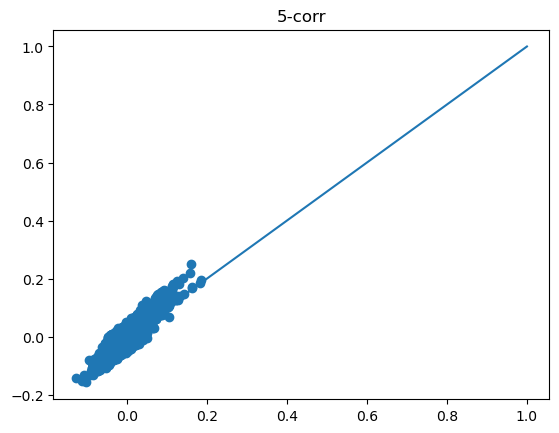

In [113]:

for i in range(3, 6):
    plt.title(f"{i}-corr")
    plt.scatter(k_corr(bin_cat_p, i), k_corr(solver.model.sample, i))
    plt.plot([0,1], [0,1])
    plt.show()




# Running sampling on model

In [114]:
from coniii.utils import *

In [115]:
import numpy as np
from numba import jit,njit

# define new e functions
@njit(cache=True)
def fast_sum(J, s):
    """Helper function for calculating energy in calc_e(). Iterates couplings J."""
    e = np.zeros(s.shape[0])
    for n in range(s.shape[0]):
        k = 0
        for i in range(s.shape[1]-1):
            for j in range(i+1,s.shape[1]):
                e[n] += J[k]*s[n,i]*s[n,j]
                k += 1
    return e

@njit("float64[:](int64[:,:],float64[:])")
def calc_e(s, params):
    """
    Parameters
    ----------
    s : 2D ndarray of ints
        state either {0,1} or {+/-1}
    params : ndarray
        (h, J) vector

    Returns
    -------
    E : ndarray
        Energies of all given states.
    """
    
    e = -fast_sum(params[s.shape[1]:],s)
    e -= np.sum(s*params[:s.shape[1]],1)
    return e

    return calc_e

In [116]:
from numba import jit

def metropolis(initial_v, multiplier, temp, bootStrap = 1000, samples = 100000):
    """
    Re-write of the metropolis algorithm to include temperature as a parameter
    """
    
    net_spin = []
    energy_spin = []
    
    current_vec = initial_v.copy()
    for i in range(0, 100000):
        E_i = calc_e(current_vec.reshape(1,-1), multiplier)[0]

        # permutate vector
        index = np.random.randint(0, high=current_vec.shape[1])
        mu_vector = current_vec.copy()
        mu_vector[:, index] *= -1

        E_u = calc_e(mu_vector.reshape(1,-1), multiplier)[0]

        # accept or reject altered vector
        dE = E_u - E_i
        if (dE > 0) * (np.random.random() < np.exp(-temp * dE)):
            current_vec = mu_vector
        elif dE <= 0:
            current_vec = mu_vector

        if i > 10000 - bootStrap:
            net_spin += [current_vec.sum()]
            energy_spin += [calc_e(current_vec.reshape(1,-1), multiplier)[0]]

    return current_vec, net_spin, energy_spin
    

In [117]:
# find phase graph
vec_neg = 2*(np.random.random(size=(1,N)) > 0.90)-1
vec_pos = vec_neg * -1

pos_avg_spin = []
neg_avg_spin = []

pos_avg_energy_c = []
neg_avg_energy_c = []

range_A = np.arange(0.1, 3, 0.1)
for temp in range_A:
    print(f"temp: {temp}")
    _, net_spin_neg, net_energy_neg = metropolis(vec_neg.copy(), stim_0_multipliers, 1/temp)
    _, net_spin_pos, net_energy_pos = metropolis(vec_pos.copy(), stim_0_multipliers, 1/temp)

    pos_avg_spin += [ net_spin_pos ]
    neg_avg_spin += [ net_spin_neg ]

    pos_avg_energy_c += [ net_energy_pos ]
    neg_avg_energy_c += [ net_energy_neg ]
    

temp: 0.1
temp: 0.2
temp: 0.30000000000000004
temp: 0.4
temp: 0.5
temp: 0.6
temp: 0.7000000000000001
temp: 0.8
temp: 0.9
temp: 1.0
temp: 1.1
temp: 1.2000000000000002
temp: 1.3000000000000003
temp: 1.4000000000000001
temp: 1.5000000000000002
temp: 1.6
temp: 1.7000000000000002
temp: 1.8000000000000003
temp: 1.9000000000000001
temp: 2.0
temp: 2.1
temp: 2.2
temp: 2.3000000000000003
temp: 2.4000000000000004
temp: 2.5000000000000004
temp: 2.6
temp: 2.7
temp: 2.8000000000000003
temp: 2.9000000000000004


# calculating heat capacity and critical temperature

In [118]:
heat_capacity = lambda x: np.power(np.asarray(x),2).mean() - np.power(np.asarray(x).mean(), 2)

In [119]:
pos_avg_pos = [np.mean(r)/N**2 for r in pos_avg_spin]
pos_avg_energy = [np.mean(r) for r in pos_avg_energy_c]
neg_avg_pos = [np.mean(r)/N**2 for r in neg_avg_spin]
neg_avg_energy = [np.mean(r) for r in neg_avg_energy_c]

avg_heat_capacity_pos = [heat_capacity(r) for r in pos_avg_energy_c]
avg_heat_capacity_neg = [heat_capacity(r) for r in neg_avg_energy_c]

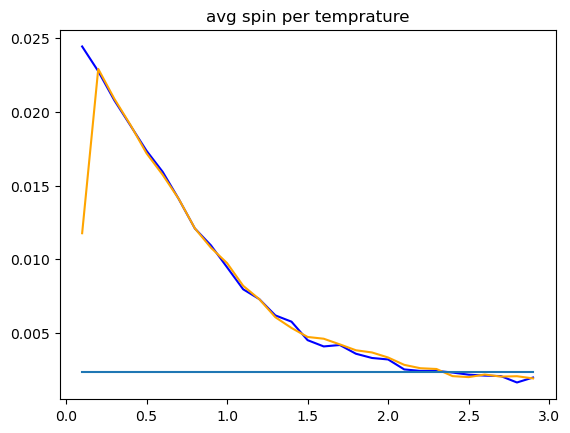

Critical temperature: 1.1
Critical energy: -2.944226040190003


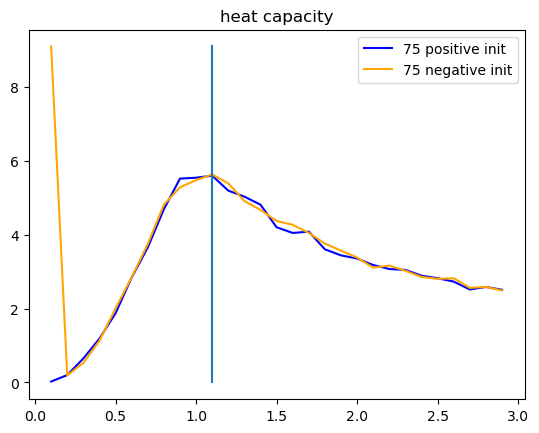

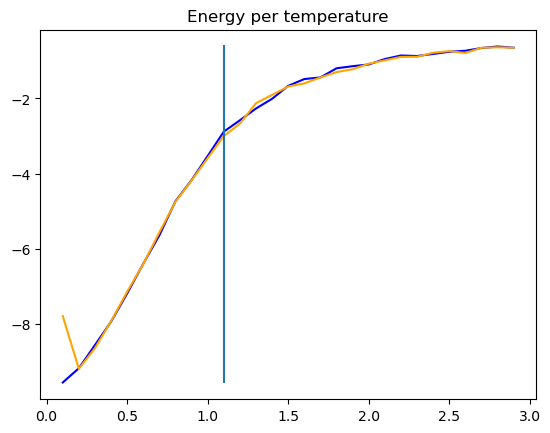

In [121]:
# Temp 0-400
plt.title("avg spin per temprature")
plt.plot(range_A, pos_avg_pos, c='blue')
plt.plot(range_A, neg_avg_pos, c='orange')

# resting point
conv_bar = np.mean(neg_avg_pos[-10:])
plt.plot([range_A[0],range_A[-1]], [conv_bar, conv_bar])
plt.show()

critical_temp_idx = np.argmax(avg_heat_capacity_pos)
c_temp = range_A[critical_temp_idx]
critical_energy = (pos_avg_energy[critical_temp_idx] + neg_avg_energy[critical_temp_idx])/2

print(f"Critical temperature: {c_temp}")
print(f"Critical energy: {critical_energy}")


plt.title("heat capacity")
plt.plot(range_A, avg_heat_capacity_pos, c='blue', label="75 positive init")
plt.plot(range_A, avg_heat_capacity_neg, c='orange', label="75 negative init")
plt.plot([c_temp,c_temp],[0, max(avg_heat_capacity_neg + avg_heat_capacity_neg)])
plt.legend(loc='best')
plt.savefig("heat capacity")
plt.show()


plt.clf()
plt.title("Energy per temperature")
plt.plot(range_A, pos_avg_energy, c='blue')
plt.plot(range_A, neg_avg_energy, c='orange')
plt.plot([c_temp, c_temp],[min(pos_avg_energy + neg_avg_energy), max(pos_avg_energy + neg_avg_energy)])
plt.show()


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


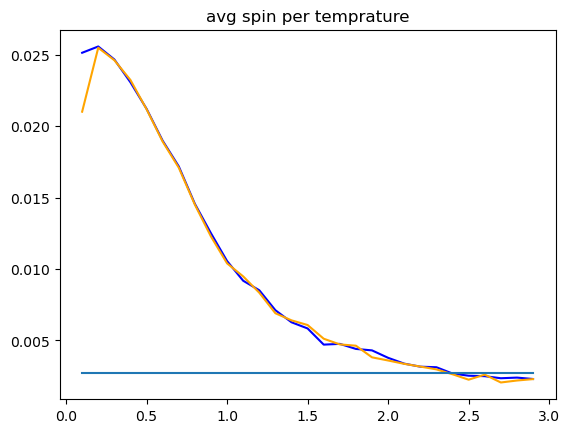

Critical temperature: 1.0
Critical energy: -3.616087625625969


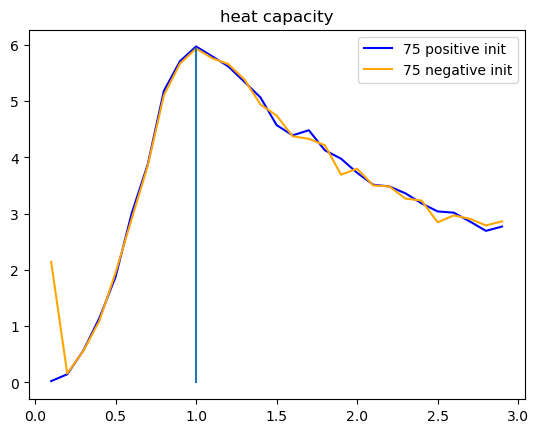

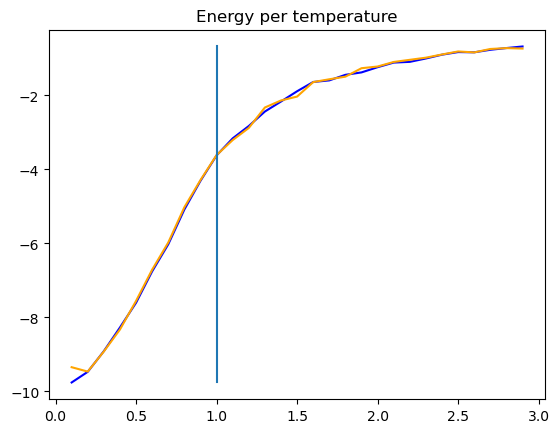

In [68]:
plt.title("avg spin per temprature")
plt.plot(range_A, pos_avg_pos, c='blue')
plt.plot(range_A, neg_avg_pos, c='orange')

# resting point
conv_bar = np.mean(neg_avg_pos[-10:])
plt.plot([range_A[0],range_A[-1]], [conv_bar, conv_bar])
plt.show()

critical_temp_idx = np.argmax(avg_heat_capacity_pos)
c_temp = range_A[critical_temp_idx]
critical_energy = (pos_avg_energy[critical_temp_idx] + neg_avg_energy[critical_temp_idx])/2

print(f"Critical temperature: {c_temp}")
print(f"Critical energy: {critical_energy}")


plt.title("heat capacity")
plt.plot(range_A, avg_heat_capacity_pos, c='blue', label="75 positive init")
plt.plot(range_A, avg_heat_capacity_neg, c='orange', label="75 negative init")
plt.plot([c_temp,c_temp],[0, max(avg_heat_capacity_neg + avg_heat_capacity_neg)])
plt.legend(loc='best')
plt.savefig("heat capacity")
plt.show()


plt.clf()
plt.title("Energy per temperature")
plt.plot(range_A, pos_avg_energy, c='blue')
plt.plot(range_A, neg_avg_energy, c='orange')
plt.plot([c_temp, c_temp],[min(pos_avg_energy + neg_avg_energy), max(pos_avg_energy + neg_avg_energy)])
plt.show()


In [122]:
from scipy.interpolate import CubicSpline

f = CubicSpline(range_A, pos_avg_energy)

In [123]:
def fast_sum(J, s):
    e = np.zeros(s.shape[0])
    for n in range(s.shape[0]):
        k = 0
        for i in range(s.shape[1]-1):
            for j in range(i+1,s.shape[1]):
                e[n] += J[k]*s[n,i]*s[n,j]
                k += 1
    return e
    
def calc_e_is(spins, params):
    e = -fast_sum(params[spins.shape[1]:],spins)
    e -= np.sum(spins*params[:spins.shape[1]],1)
    return e

In [124]:
x_stim_0 = np.array([continous_stim[0][i][:,0] for i in range(0, len(continous_stim[0]))])
x_stim_1 = np.array([continous_stim[1][i][:,0] for i in range(0, len(continous_stim[1]))])
x_stim_2 = np.array([continous_stim[2][i][:,0] for i in range(0, len(continous_stim[2]))])

neural_0 = (np.asarray([neural_stim[0][i][:,:] for i in range(0, len(neural_stim[0]))]) > 0)*1
neural_1 = (np.asarray([neural_stim[1][i][:,:] for i in range(0, len(neural_stim[1]))]) > 0)*1
neural_2 = (np.asarray([neural_stim[2][i][:,:] for i in range(0, len(neural_stim[2]))]) > 0)*1

e_0 = np.asarray([calc_e_is(i , stim_0_multipliers) for i in neural_0])
e_1 = np.asarray([calc_e_is(i , stim_0_multipliers) for i in neural_1])
e_2 = np.asarray([calc_e_is(i , stim_0_multipliers) for i in neural_2])

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

mean_stim_0, lower_stim_0, upper_stim_0 = [],[],[]
ci = 0.8
for i in range (x_stim_0.shape[1]):
    # a = np.random.rand(100) # this is the output
    m, ml, mu = mean_confidence_interval(x_stim_0[:, i], ci)
    mean_stim_0.append(m)
    lower_stim_0.append(ml)
    upper_stim_0.append(mu)


mean_stim_1 = []
for i in range (x_stim_1.shape[1]):
  m, _, _ = mean_confidence_interval(x_stim_1[:, i], ci)
  mean_stim_1.append(m)

mean_stim_2 = []
for i in range (x_stim_2.shape[1]):
  m, _, _ = mean_confidence_interval(x_stim_2[:, i], ci)
  mean_stim_2.append(m)

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

mean, lower, upper = [],[],[]
ci = 0.8
for i in range (e_0.shape[1]):
    # a = np.random.rand(100) # this is the output
    m, ml, mu = mean_confidence_interval(e_0[:, i], ci)
    mean.append(m)
    lower.append(ml)
    upper.append(mu)


mean_1 = []
for i in range (e_1.shape[1]):
  m, _, _ = mean_confidence_interval(e_1[:, i], ci)
  mean_1.append(m)

mean_2 = []
for i in range (e_2.shape[1]):
  m, _, _ = mean_confidence_interval(e_2[:, i], ci)
  mean_2.append(m)

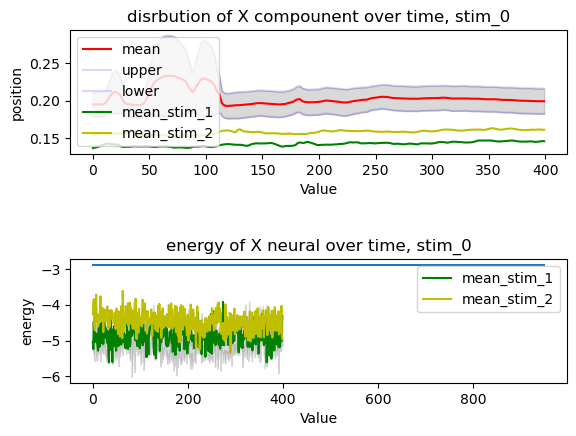

In [127]:
# Temp 0-400

plt.figure()

plt.subplot(2,1,1)
plt.title("disrbution of X compounent over time, stim_0")

plt.plot(mean_stim_0,'-r', label='mean')
plt.plot(upper_stim_0,'-b', label='upper', alpha=0.15)
plt.plot(lower_stim_0,'-b', label='lower', alpha=0.15)

plt.plot(mean_stim_1, '-g', label="mean_stim_1")
plt.plot(mean_stim_2, '-y', label="mean_stim_2")

# fill the area with black color, opacity 0.15
plt.fill_between(list(range(len(mean_stim_0))), upper_stim_0, lower_stim_0, color="k", alpha=0.15)

plt.xlabel("Value")
plt.ylabel("position")
plt.legend()

plt.subplot(2,1,2)
plt.title("energy of X neural over time, stim_0")

# plt.plot(mean,'-r', label='mean')
# plt.plot(upper,'-b', label='upper', alpha=0.15)
# plt.plot(lower,'-b', label='lower', alpha=0.15)

plt.plot(mean_1, '-g', label="mean_stim_1")
plt.plot(mean_2, '-y', label="mean_stim_2")

# fill the area with black color, opacity 0.15
plt.fill_between(list(range(len(mean))), upper, lower, color="k", alpha=0.15)


plt.tight_layout(pad=3.0)

plt.xlabel("Value")
plt.ylabel("energy")
plt.legend()

plt.plot([0,950],[f(c_temp), f(c_temp)])

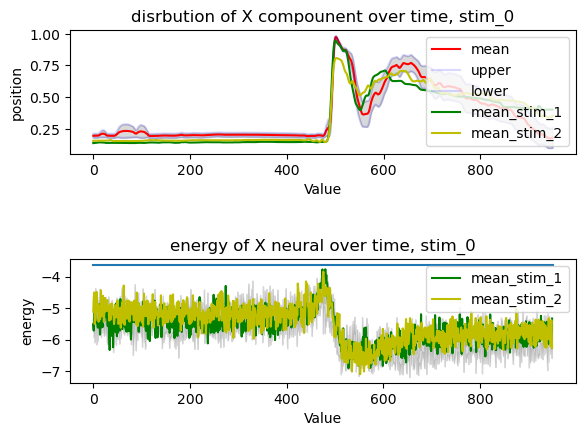

In [82]:
plt.figure()


plt.subplot(2,1,1)
plt.title("disrbution of X compounent over time, stim_0")

plt.plot(mean_stim_0,'-r', label='mean')
plt.plot(upper_stim_0,'-b', label='upper', alpha=0.15)
plt.plot(lower_stim_0,'-b', label='lower', alpha=0.15)

plt.plot(mean_stim_1, '-g', label="mean_stim_1")
plt.plot(mean_stim_2, '-y', label="mean_stim_2")

# fill the area with black color, opacity 0.15
plt.fill_between(list(range(len(mean_stim_0))), upper_stim_0, lower_stim_0, color="k", alpha=0.15)

plt.xlabel("Value")
plt.ylabel("position")
plt.legend()

plt.subplot(2,1,2)
plt.title("energy of X neural over time, stim_0")

# plt.plot(mean,'-r', label='mean')
# plt.plot(upper,'-b', label='upper', alpha=0.15)
# plt.plot(lower,'-b', label='lower', alpha=0.15)

plt.plot(mean_1, '-g', label="mean_stim_1")
plt.plot(mean_2, '-y', label="mean_stim_2")

# fill the area with black color, opacity 0.15
plt.fill_between(list(range(len(mean))), upper, lower, color="k", alpha=0.15)


plt.tight_layout(pad=3.0)

plt.xlabel("Value")
plt.ylabel("energy")
plt.legend()

plt.plot([0,950],[f(c_temp), f(c_temp)])

# Questions to Explore

* What are the different states in this graph?
* * What do they imply about the state of the neurons cluster
  * How would we prove the interpretation
* Could we abstract this anaylsis to a more general analysis?
* If we chain all spike configuration together for all reaches in a session, do we see this drop constantly
* Why does the spike reach up to where it is at?
* * Could we time the event of the spike on this jump?
* can we use the ratio in H,J values to weight the neurons outside input to the neural internal chat
* Look at Y,Z charts _=***
* Does critical temperature stay the same for the before reach, reach, and after reach
* How many neurons are corrlated, during the different phase in the reach?
* Do we see the same behavior in the pre-reach area? (This would help understand the meaning the analysis)